<a href="https://colab.research.google.com/github/Darian-Lee-YTKA/changing-All-NBA-selection-criteria-over-time/blob/main/current_RandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The first random forest will look at feature importance in the first and last 5 years in the data set (thus with a little over a decade in between the 2 models)

In [ ]:
import pandas as pd
import numpy as np

big_df = pd.read_csv("/content/scaled_data.csv")


print(big_df['Year'].unique()) # to see which years are included

# initial preprocessing
# for random forests we should binary encode all the categorical variables


big_df = big_df[pd.notna(big_df['All_NBA'])]
big_df['All_NBA'] = big_df['All_NBA'].apply(lambda x: 0 if x == False else 1)
big_df.drop(big_df.columns[0], axis=1, inplace=True) # we dont need names
big_df.drop("All_NBA_Team", axis = 1, inplace=True)

# we will delete voting points at all to prevent our analysis from being arbitrary

big_df.drop("Voting_Points", axis = 1, inplace=True)

# encode the positions as numbers
counter = 0
for pos in big_df['Pos'].unique():
  print(pos)
  big_df['Pos'] = big_df['Pos'].apply(lambda x: counter if x == pos else x)
  counter += 1



# making the datasets for each time period; 'past' will store the data from 2004-2008, and 'current' will store data from over a decade later, i.e. 2019- 2023


past = big_df[big_df['Year'] <= 2008]
past.drop('Year', axis=1, inplace= True)

current = big_df[(big_df['Year'] >= 2019) & (big_df['Year'] < 2024)] #remove year 2024 since the team hasnt been choosen yet
current.drop('Year', axis=1, inplace = True)



[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024]
Frontcourt
Backcourt


<ipython-input-1-0762d1b961c0>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past.drop('Year', axis=1, inplace= True)
<ipython-input-1-0762d1b961c0>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current.drop('Year', axis=1, inplace = True)


In [ ]:
current.head()



Pos  All_NBA       PTS       TRB       AST       BLK       STL  \
7034    1        0 -0.716051 -0.812832 -0.731300 -0.586027 -0.573088   
7035    0        0 -1.017825 -0.928494 -0.824539 -0.655009 -1.070558   
7036    1        0 -0.832275 -0.752487 -0.381652 -0.620518 -0.666363   
7037    0        0  1.206738  2.767663  0.076776  1.828364  2.536099   
7038    0        0  0.433952  1.947971  0.542973  1.448960  1.105873   

           W.L       FGA       FG.      eFG.        FT       FT.        MP  \
7034  0.725232 -0.682106 -0.741475 -0.111624 -0.715635  1.052793 -0.636277   
7035 -2.055896 -1.050925 -1.948778 -1.865718 -0.766705  0.015006 -1.190735   
7036 -1.128853 -0.806815 -0.848791 -0.346622 -0.766705  0.377999 -0.827058   
7037  0.725232  1.047891  1.386956  0.794798  0.653041 -0.915745  1.845069   
7038 -0.201810  0.190852  1.217039  0.660513  0.857320  0.177888  0.943628   

             G        GS  
7034 -0.700500 -0.757735  
7035 -1.506681 -0.829194  
7036 -0.585332 -0.793464  
7037  1.180587  2.029165  
7038  1.257366  0.171232

In [ ]:
big_df.shape

(9777, 17)

In [ ]:
current.shape

(2743, 16)

In [ ]:
past.shape

(2272, 16)

In [ ]:
# note to self, edit this later and delete imports you don't need

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

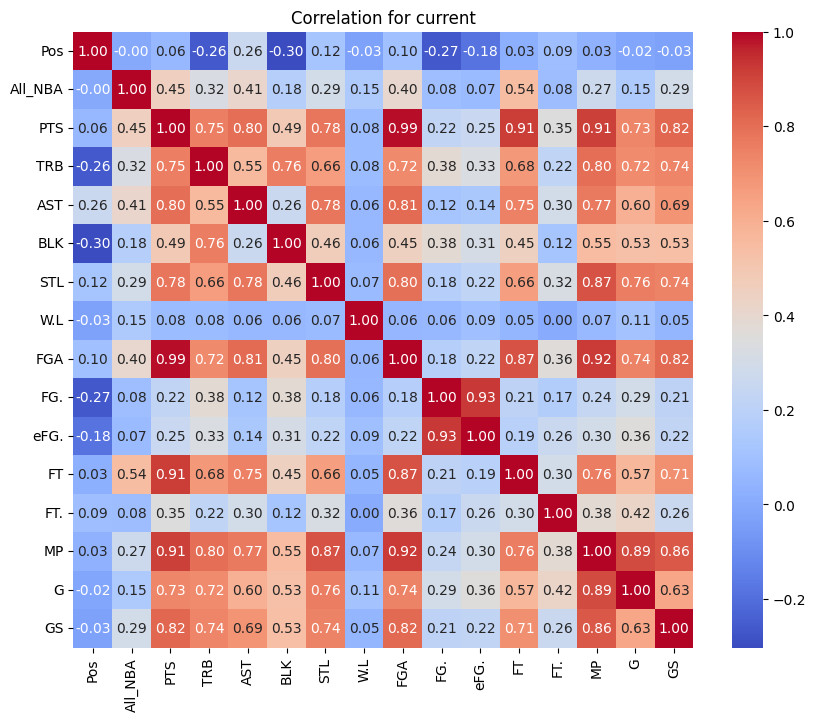

In [ ]:
# some visualization

correlation_matrix = current.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation for current')
plt.show()

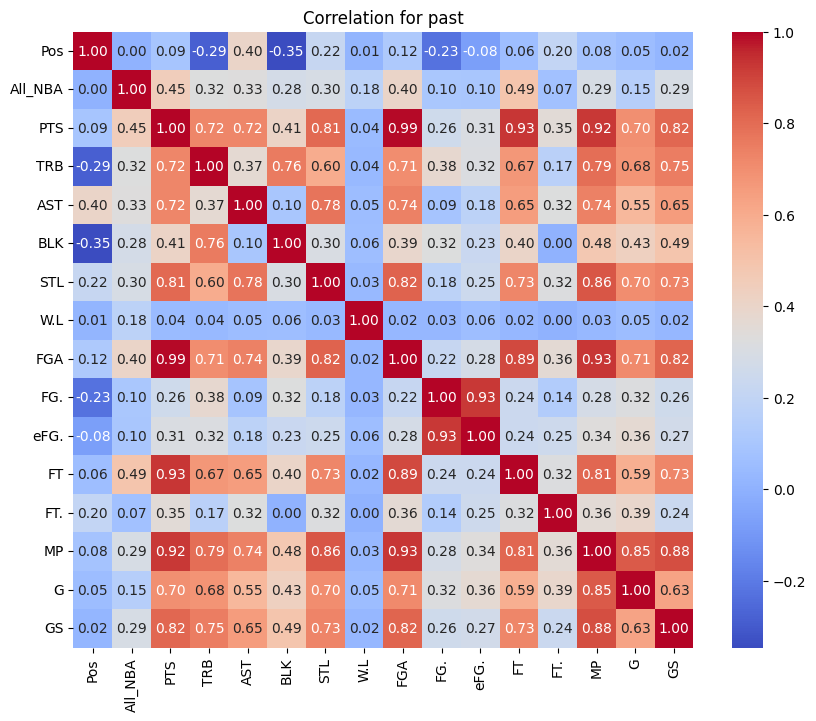

In [ ]:
correlation_matrix = past.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation for past')
plt.show()

Our main goal is to assess whether the influence each feature has on a player's likelihood of making All-NBA teams has evolved over time. To investigate this, I plan to utilize the Central Limit Theorem (CLT). The CLT states that for a large enough sample size, the distribution of a vector of sample means approaches a normal distribution, centered at the mean of the sample means vector and with a standard deviation equal to the standard deviation of the sample means vector. For each time period (past and current), I will be running 800 different random forests. For each random forest, I will calculate the feature significance for each of the 200 trees in the random forest and then take the mean of those data points for each feature. I will then have a dataset of 800 means for each feature represeting the average importance of that feature in each random forest. Thus the distribution of these 800 points should be approixametly normal based on the CLT because it is a distribution of means.

I will then compare the past (2004-2008) and current(2020-2024) distributions using t-tests (which assumes normality) to see if the difference in estimates for feature importance are statistically significant. If the differences are statistically significant for a feature, it means that the importance this feature has in determining if a player makes all NBA has changed between 2008 and 2020

After seeing which features importances have changed, I will explore the extent to which the changes occured using side by side graphs and other visual representations

In [ ]:
# since we will need to do all the same steps for each df, I will wrap the steps into a function



def run_decision_tree(df):
  y = df['All_NBA']
  X = df.drop(['All_NBA', 'Pos'], axis = 1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)




  # start the random forest

  accuracies = []
  means = pd.DataFrame(columns=X_train.columns)
  for seed in range(0,801):
    print(seed) # this will allow me to estimate how much longer my code needs to run for

    random_forest = RandomForestClassifier(n_estimators=200, random_state = seed)
    random_forest.fit(X_train, y_train)
    predictions = random_forest.predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))
    importances_per_tree = [tree.feature_importances_ for tree in random_forest.estimators_]
    mean_importances = np.mean(importances_per_tree, axis=0)
    means.loc[seed] = mean_importances

  print("mean accuracy for random forests: ", np.mean(accuracies))

  return means, accuracies






In [ ]:
print("CURRENT")
current_means, current_accuracies = run_decision_tree(current)


CURRENT
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

In [ ]:
min(current_accuracies) # to make sure there are no forests with super low accuracies, in which case we would throw their feature importance estimates out

0.9799635701275046

mean accuracy of forests for current:  0.9847162813332152


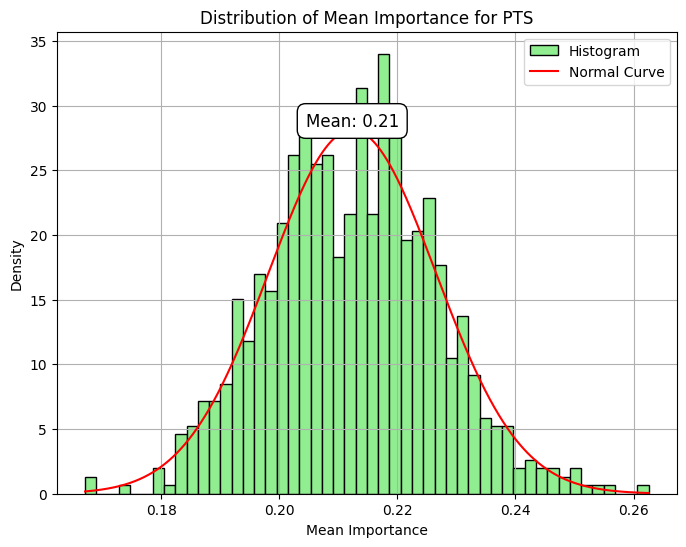

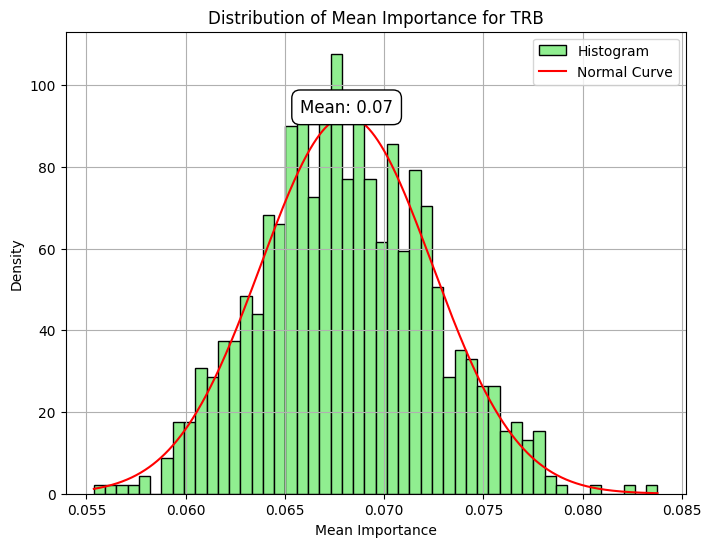

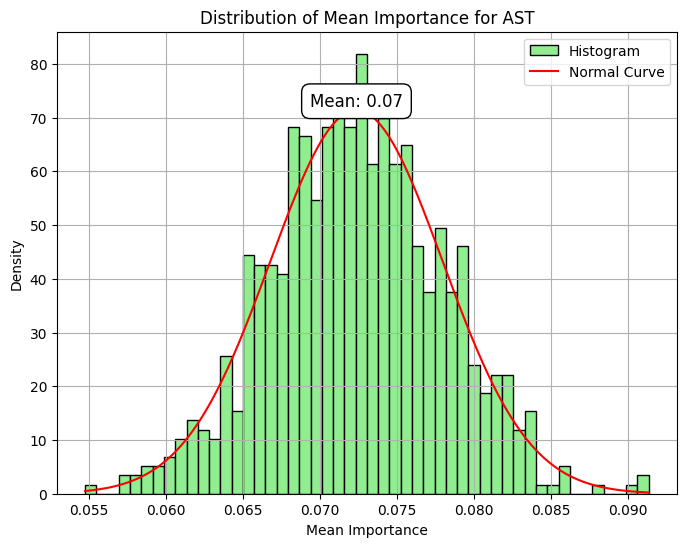

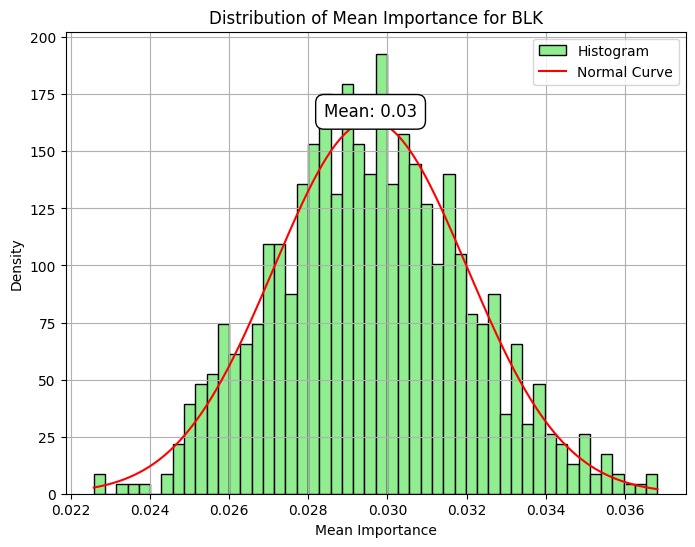

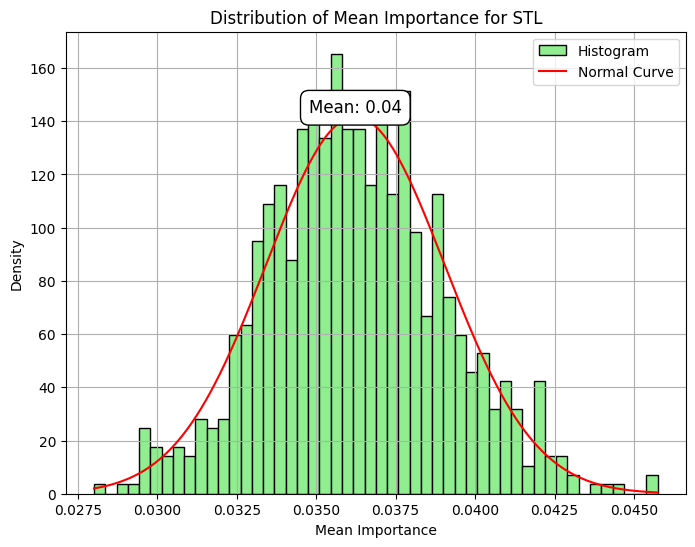

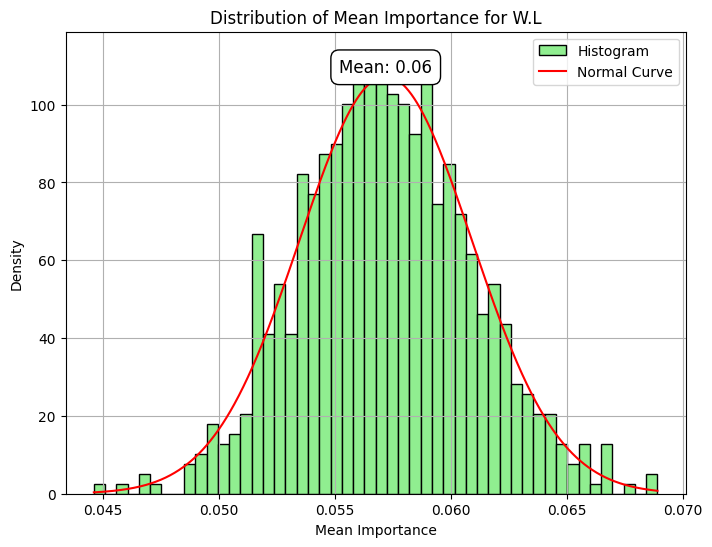

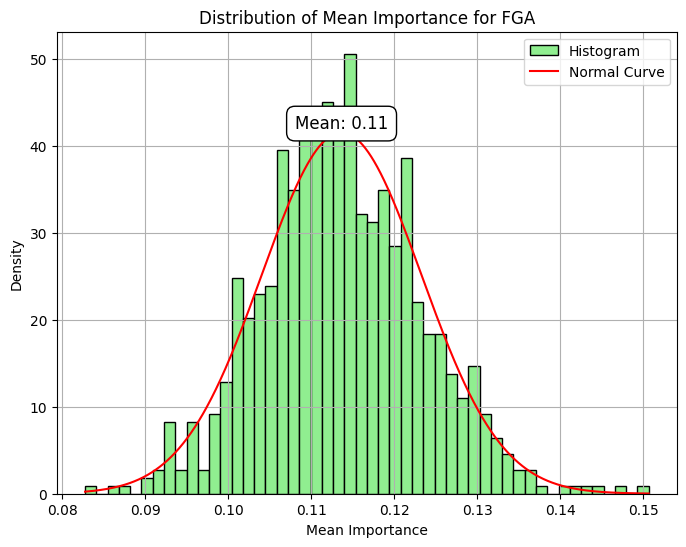

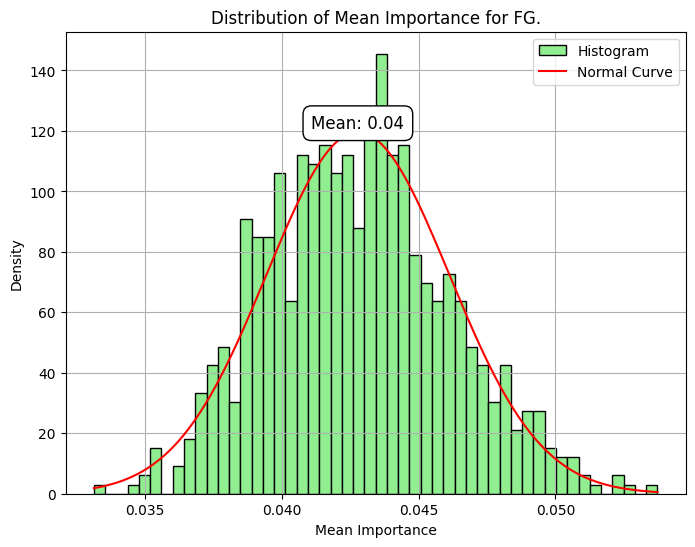

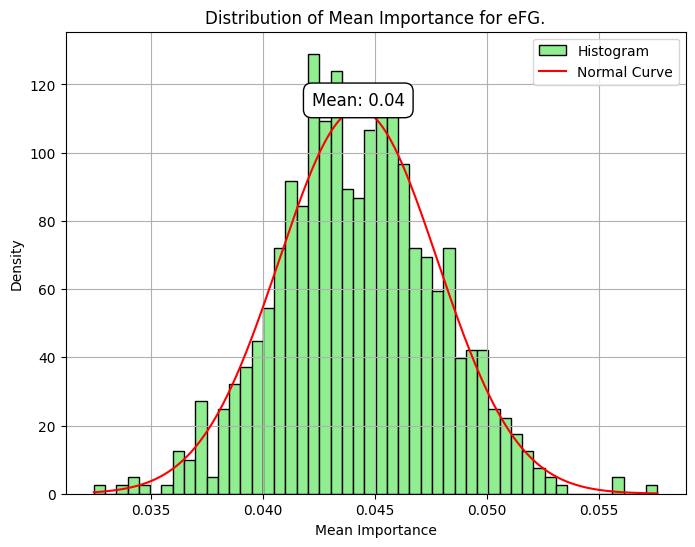

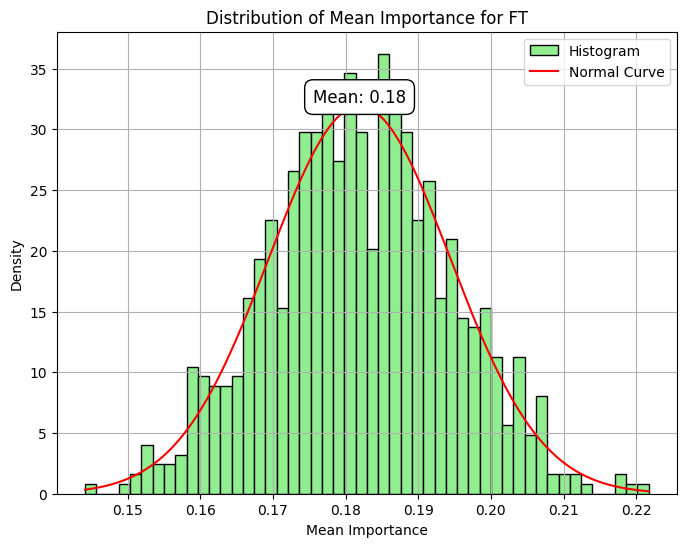

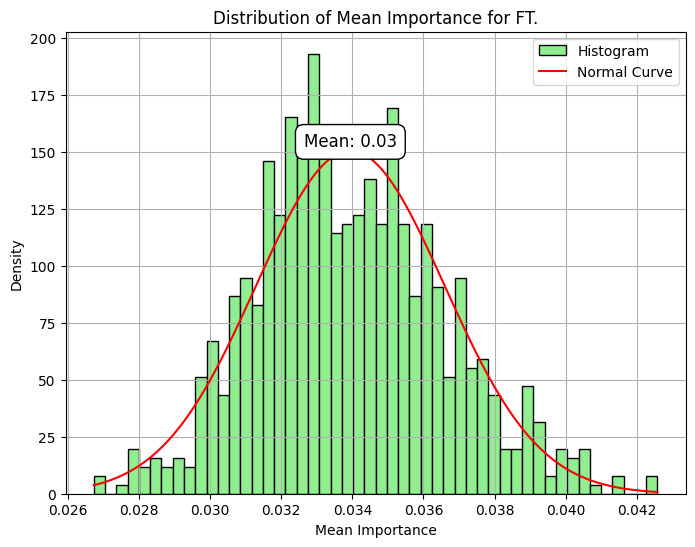

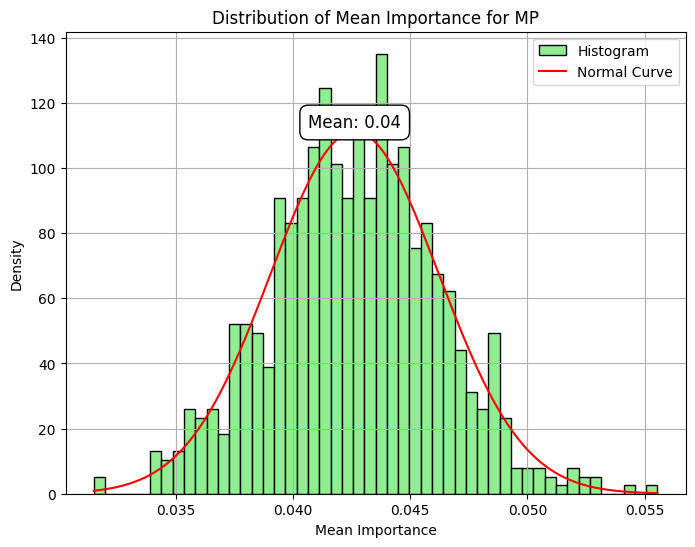

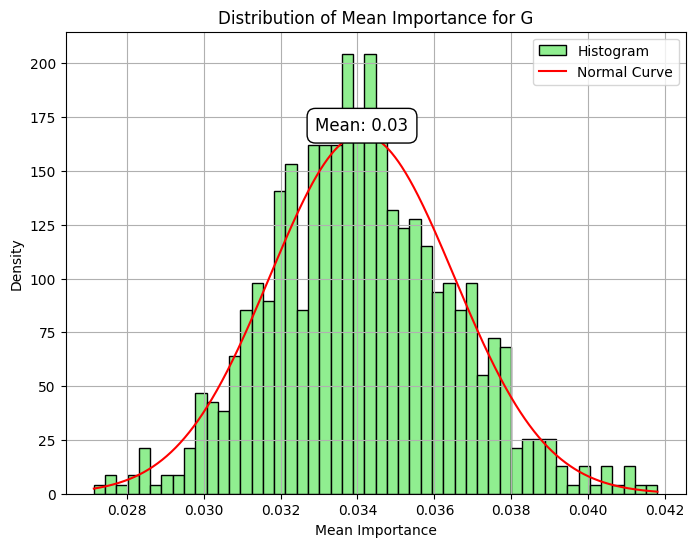

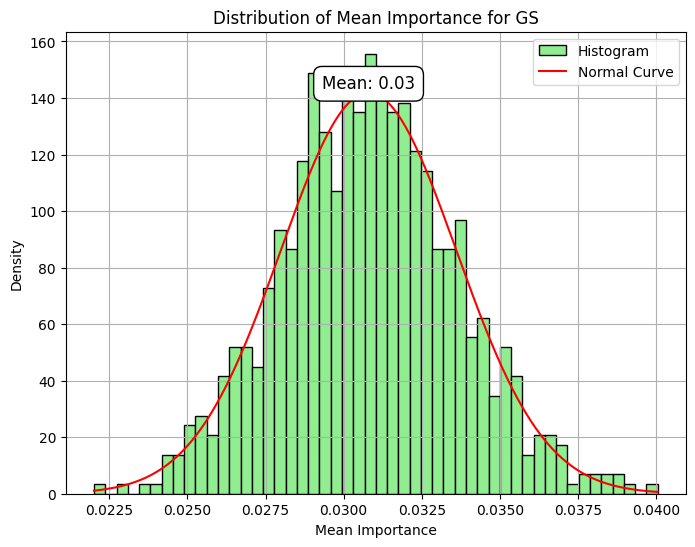

In [ ]:
import scipy.stats as stats
print("mean accuracy of forests for current: ", np.mean(current_accuracies))
for column in current_means.columns:
    plt.figure(figsize=(8, 6))

    plt.hist(current_means[column], bins=50, color='lightgreen', edgecolor='black', density=True, label='Histogram')

    mean = current_means[column].mean()
    std = current_means[column].std()


    x = np.linspace(current_means[column].min(), current_means[column].max(), 1000)
    y = stats.norm.pdf(x, mean, std)
    plt.plot(x, y, color='red', label='Normal Curve')

    plt.title(f'Distribution of Mean Importance for {column}')
    plt.xlabel('Mean Importance')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.text(mean, max(y), f'Mean: {mean:.2f}', fontsize=12, ha='center', va='bottom', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


    plt.show()

In [ ]:
print("PAST")
past_means, past_accuracies = run_decision_tree(past)

PAST
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [ ]:
min(past_accuracies) # to make sure there are no forests with super low accuracies, in which case we would throw their feature importance estimates out

0.9736263736263736

mean accuracy of forests for past:  0.9795941885829527


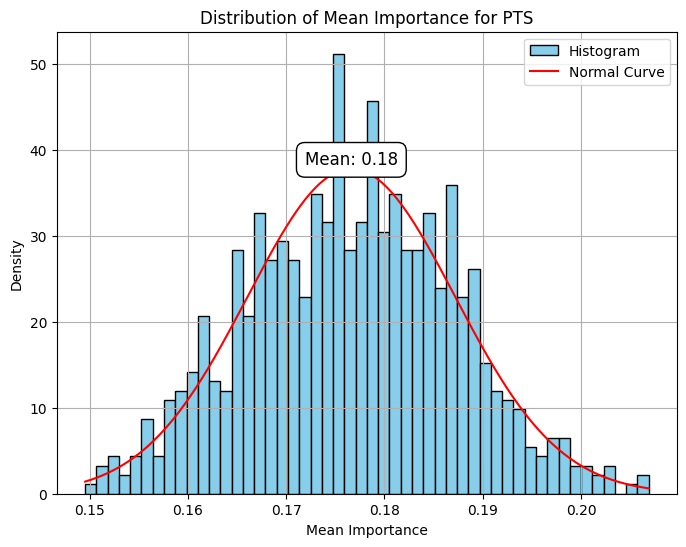

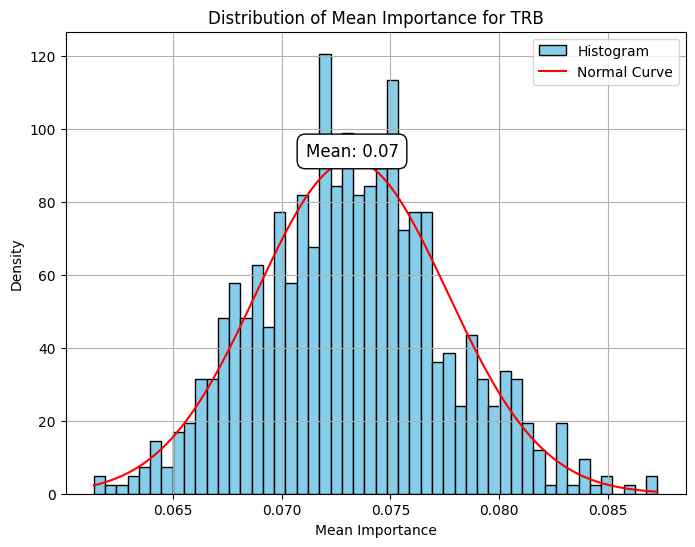

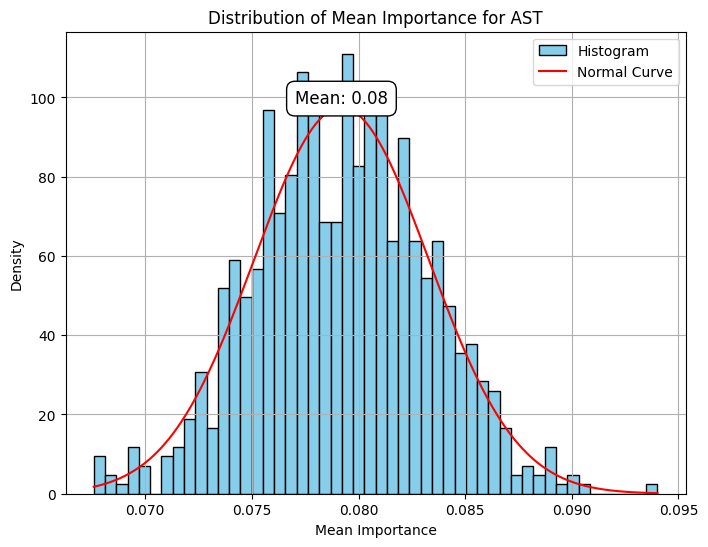

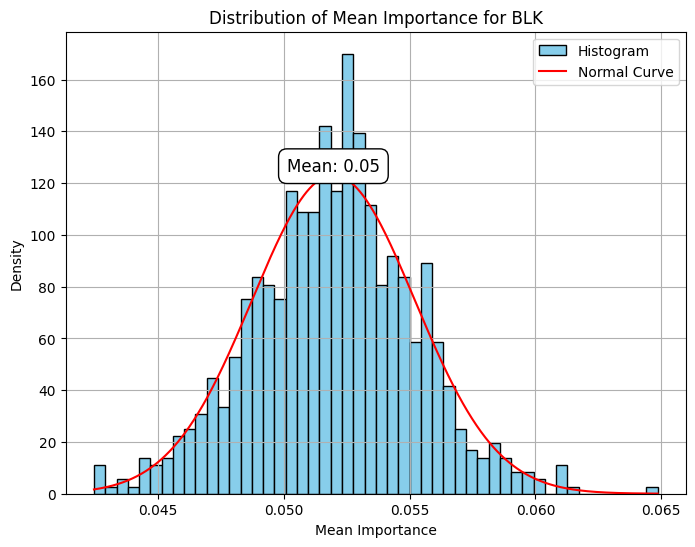

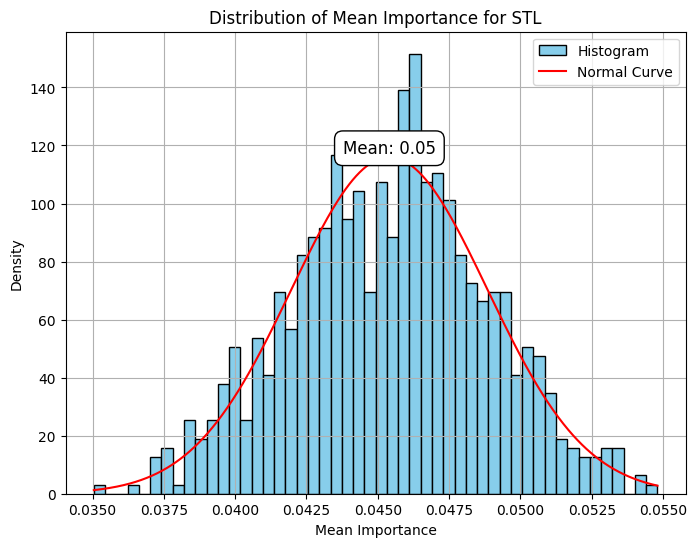

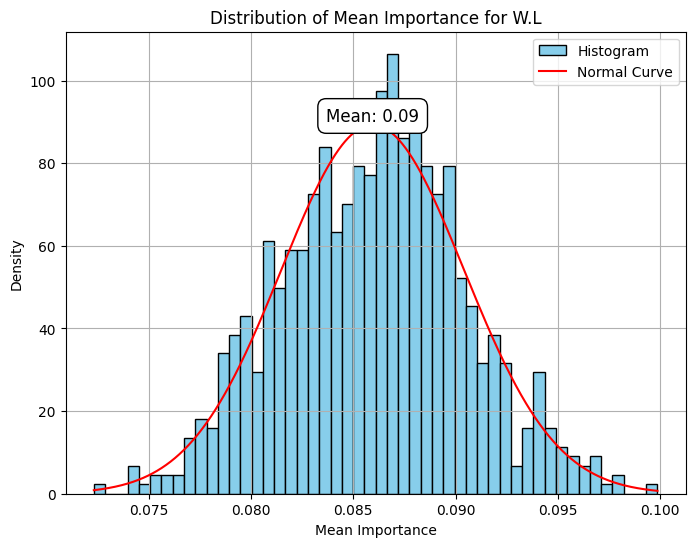

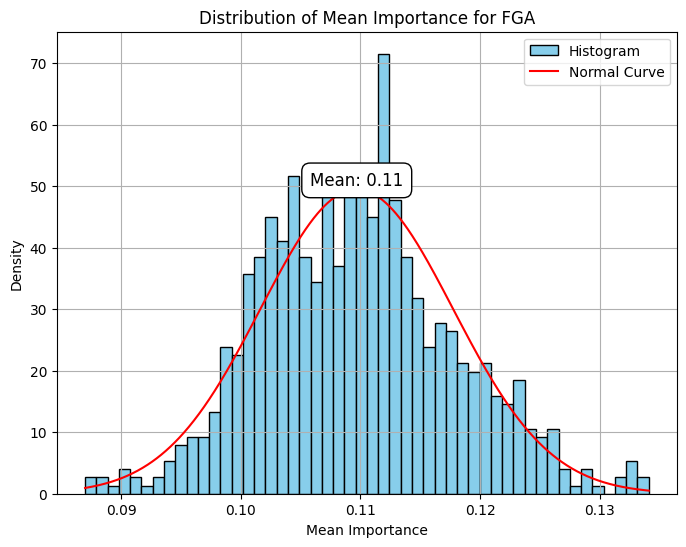

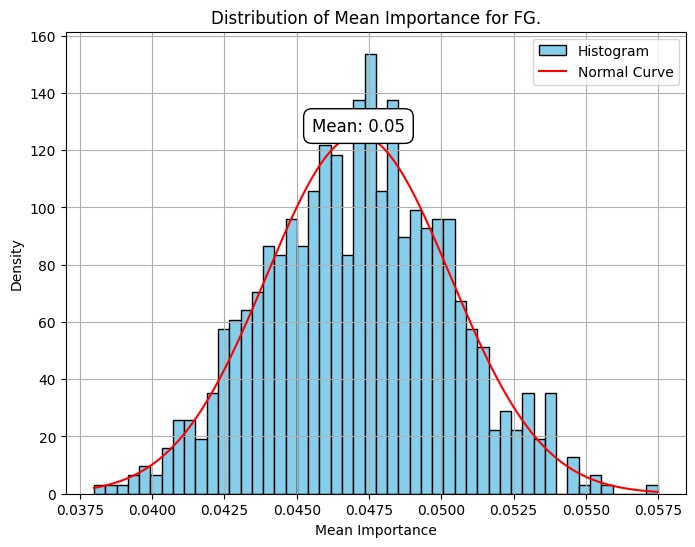

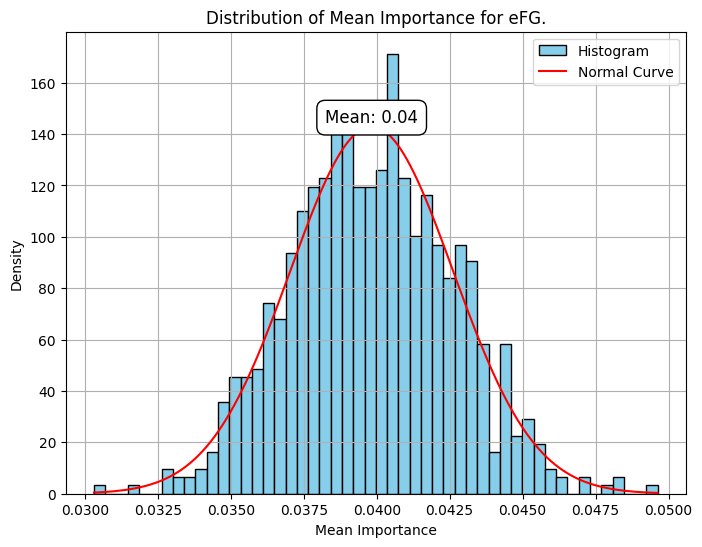

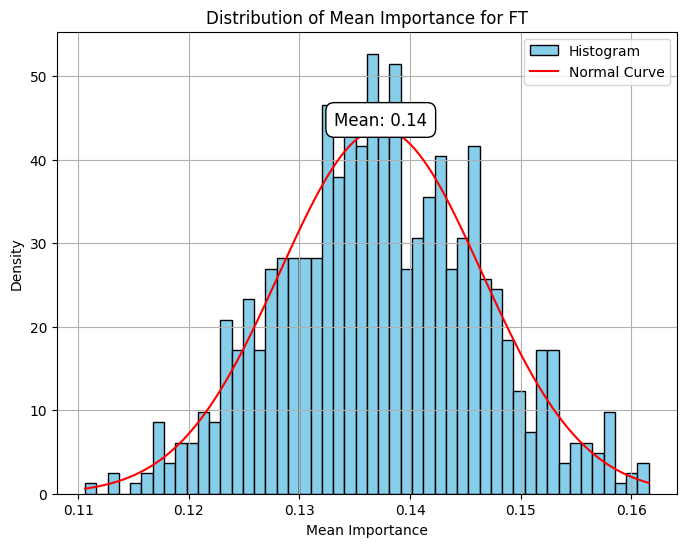

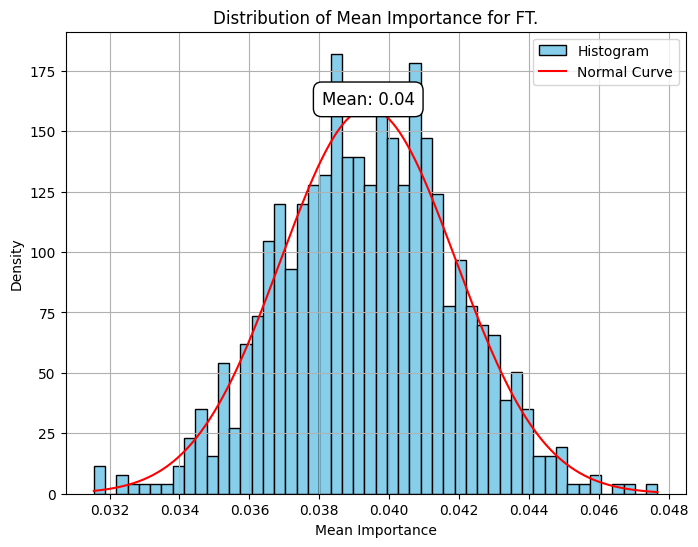

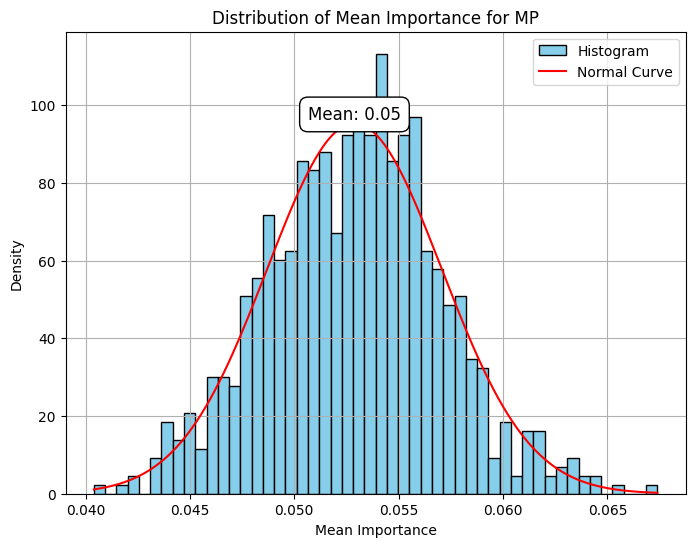

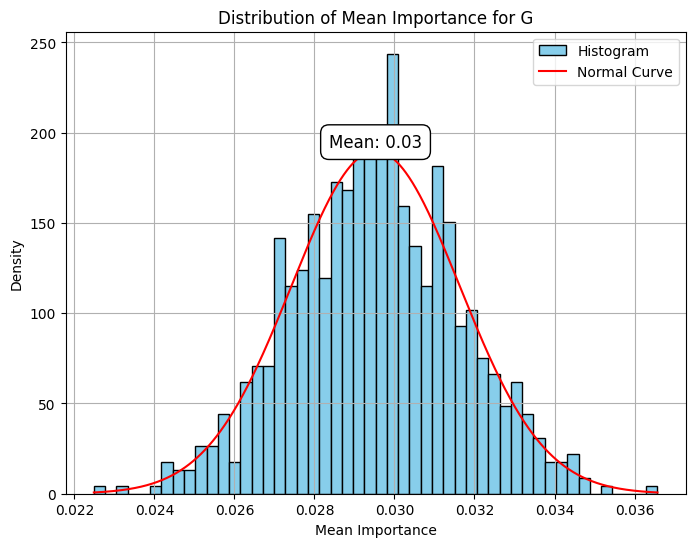

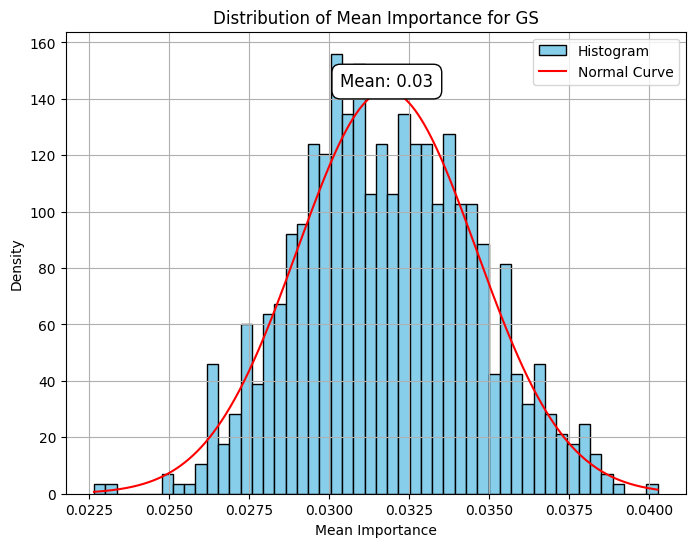

In [ ]:
print("mean accuracy of forests for past: ", np.mean(past_accuracies))

for column in past_means.columns:

    plt.figure(figsize=(8, 6))

    plt.hist(past_means[column], bins=50, color='skyblue', edgecolor='black', density=True, label='Histogram')

    mean = past_means[column].mean()
    std = past_means[column].std()


    x = np.linspace(past_means[column].min(), past_means[column].max(), 1000)
    y = stats.norm.pdf(x, mean, std)
    plt.plot(x, y, color='red', label='Normal Curve')

    plt.title(f'Distribution of Mean Importance for {column}')
    plt.xlabel('Mean Importance')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.text(mean, max(y), f'Mean: {mean:.2f}', fontsize=12, ha='center', va='bottom', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


    plt.show()


In [ ]:
for column in past_means.columns: #column names will be the same
  print("\n\npreforming t-test for feature: ", column)
  past = past_means[column]
  current = current_means[column]

  print("mean for past: ", np.mean(past), "mean for current: ", np.mean(current))
  print("sd for past: ", np.std(past), "sd for current: ", np.std(current))


  t_statistic, p_value = stats.ttest_ind(past, current)


  print("T-statistic:", t_statistic)
  print("P-value:", p_value)


  alpha = 0.05
  if p_value < alpha:
    print("Reject the null hypothesis: The means are statistically significantly different.")
  else:
    print("Fail to reject the null hypothesis: The means are not statistically significantly different.")



preforming t-test for feature:  PTS
mean for past:  0.17663150557410703 mean for current:  0.21236397583901256
sd for past:  0.010552178903386186 sd for current:  0.014181347157745704
T-statistic: -57.1756953298059
P-value: 0.0
Reject the null hypothesis: The means are statistically significantly different.


preforming t-test for feature:  TRB
mean for past:  0.07323587314106071 mean for current:  0.06811020778418955
sd for past:  0.004367791244874221 sd for current:  0.004316868392865821
T-statistic: 23.60749855457609
P-value: 5.731161545043198e-106
Reject the null hypothesis: The means are statistically significantly different.


preforming t-test for feature:  AST
mean for past:  0.07919958295316724 mean for current:  0.07238776661704048
sd for past:  0.004091950527872782 sd for current:  0.005586807711141563
T-statistic: 27.82173926177091
P-value: 2.7978979166481704e-139
Reject the null hypothesis: The means are statistically significantly different.


preforming t-test for feat

# Interpretting the t-tests

The statistical analysis indicates that estimated importance of each features impact on getting All NBA has changed for all features accross the 2 time periods. Although some of these changes were very slight (see the next graph), all of the changes in importance are statistically significant.

In [ ]:
import matplotlib.pyplot as plt

def create_feature_plot(features, means, setting):

    other_features = features[8:]
    other_mean = sum(means[8:])
    features = features[:8] + [str(features[8:-1])] # not including pos to save space and because pos has almost 0 correlation
    means = means[:8] + [other_mean]
    plt.figure(figsize=(8, 8))
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightpink', 'lavender', 'yellow', 'orange', 'lavenderblush', 'lightgrey']
    if setting == 0:
        plt.title('Top 8 most important features (2004-2008)', fontweight='bold')
    else:
        plt.title('Top 8 most important features (2019-2023)', fontweight='bold')

    plt.pie(means, labels=features, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.text(-2, 0, 'Importance ranking:', fontsize=10, color='black', weight='bold')

    for i, feature in enumerate(features, start=1):

        plt.text(-2, -i*0.1, f"{i}. {feature}", fontsize=10, color='black')

    plt.tight_layout()
    plt.show()




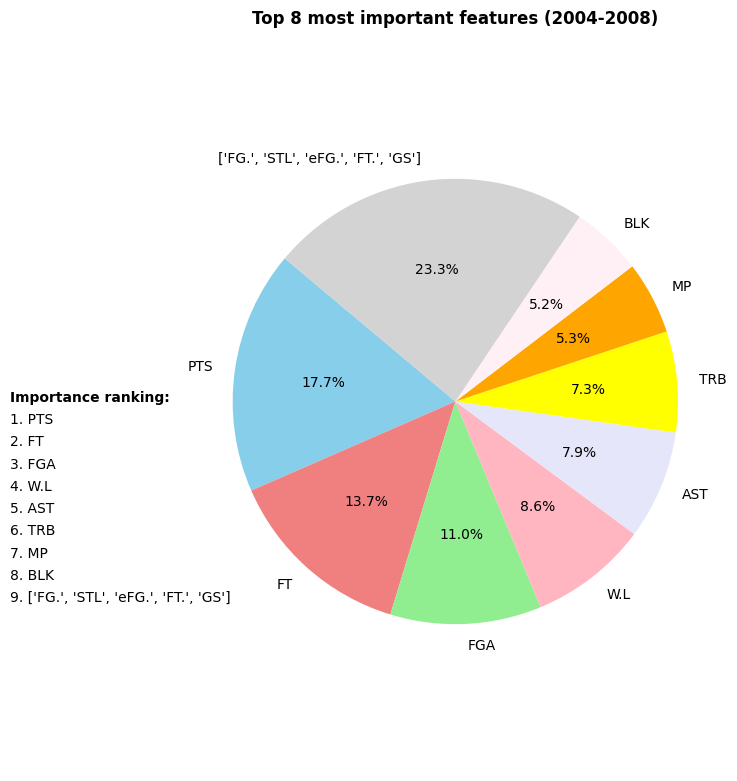

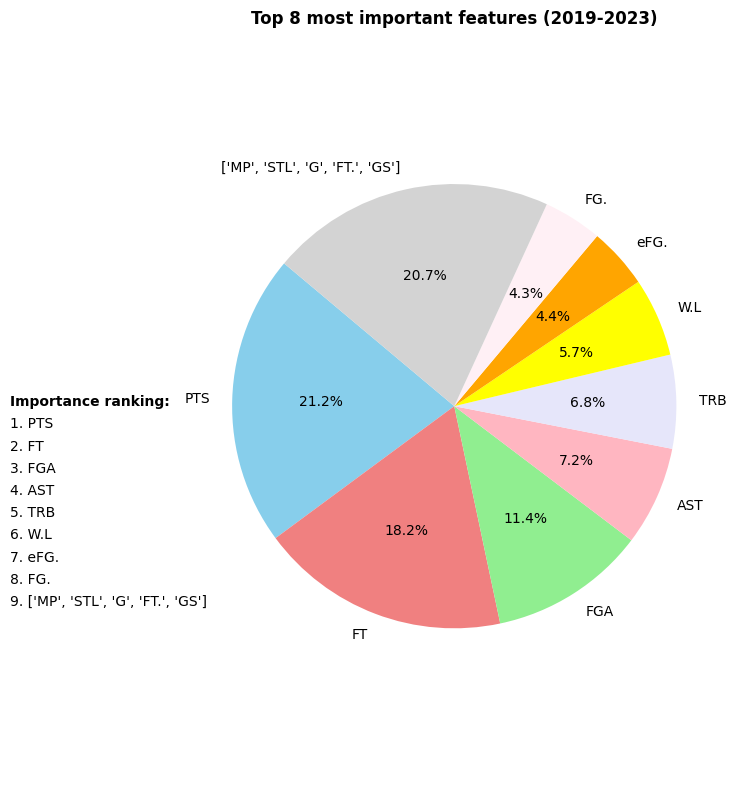

['Past: PTS, Curr: PTS', 'Past: FT, Curr: FT', 'Past: FGA, Curr: FGA', 'Past: W.L, Curr: AST', 'Past: AST, Curr: TRB', 'Past: TRB, Curr: W.L', 'Past: MP, Curr: eFG.', 'Past: BLK, Curr: FG.', 'Past: FG., Curr: MP', 'Past: STL, Curr: STL', 'Past: eFG., Curr: G', 'Past: FT., Curr: FT.', 'Past: GS, Curr: GS', 'Past: G, Curr: BLK']


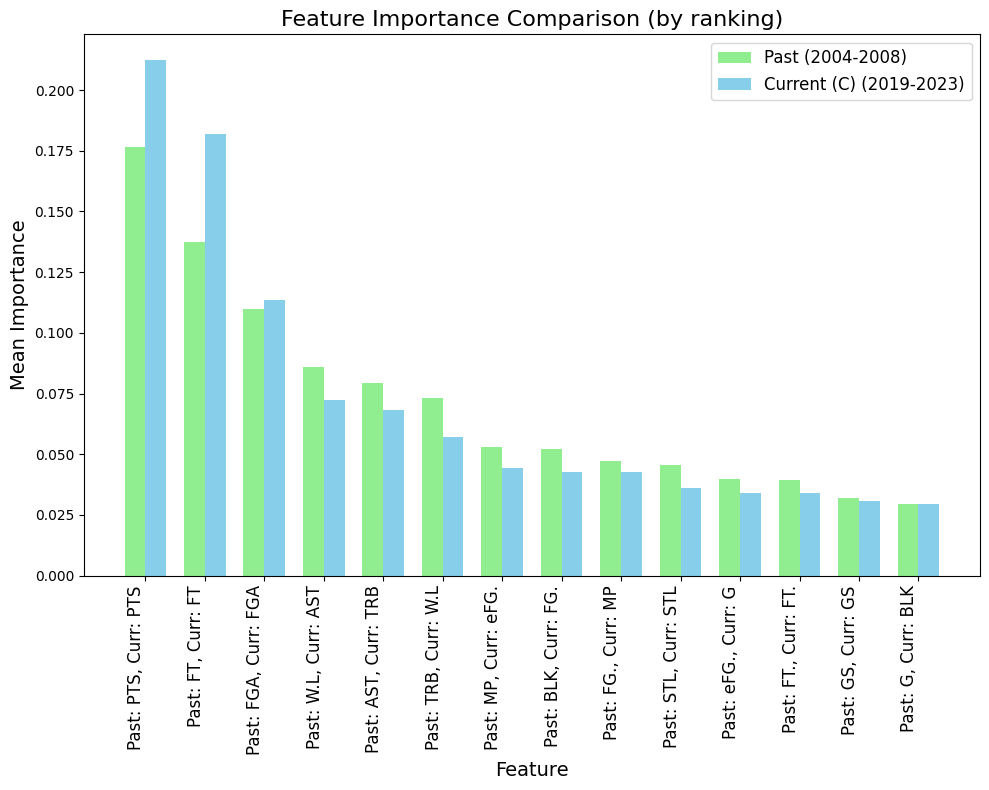

['Past: PTS, Curr: PTS', 'Past: FT, Curr: FT', 'Past: FGA, Curr: FGA', 'Past: W.L, Curr: AST', 'Past: AST, Curr: TRB', 'Past: TRB, Curr: W.L', 'Past: MP, Curr: eFG.', 'Past: BLK, Curr: FG.', 'Past: FG., Curr: MP', 'Past: STL, Curr: STL', 'Past: eFG., Curr: G', 'Past: FT., Curr: FT.', 'Past: GS, Curr: GS', 'Past: G, Curr: BLK']


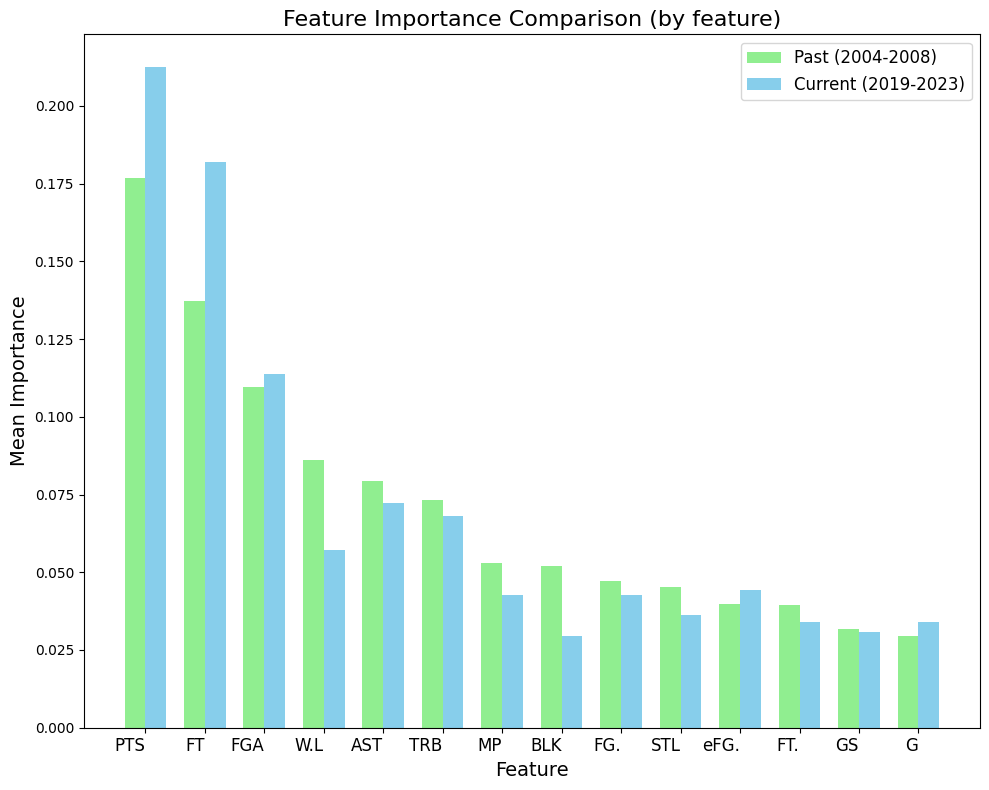

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


feature_dict_past = {}
for column in past_means.columns:
    feature_dict_past[column] = np.mean(past_means[column])

sorted_features_past = sorted(feature_dict_past.items(), key=lambda x: x[1], reverse=True)



features_past = [item[0] for item in sorted_features_past]
means_past = [item[1] for item in sorted_features_past]

create_feature_plot(features_past, means_past, 0)

feature_dict_current = {}
for column in current_means.columns:
    feature_dict_current[column] = np.mean(current_means[column])

sorted_features_current = sorted(feature_dict_current.items(), key=lambda x: x[1], reverse=True)



features_current = [item[0] for item in sorted_features_current]
means_current = [item[1] for item in sorted_features_current]

create_feature_plot(features_current, means_current, 1)

# order the current features in the same order as the past ones

current_ordered_by_past = [feature_dict_current[feature] for feature in features_past]


bar_width = 0.35
index = np.arange(len(features_past))

fig, ax = plt.subplots(figsize=(10, 8))

bar_past = ax.bar(index, means_past, bar_width, label='Past (2004-2008)', color='lightgreen')
bar_current = ax.bar(index + bar_width, means_current, bar_width, label='Current (C) (2019-2023)', color='skyblue')

features_past_and_current = []
for i in range(len(features_past)):
    features_past_and_current.append("Past: " + features_past[i] + ", Curr: " + features_current[i])


print(features_past_and_current)
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Mean Importance', fontsize=14)
ax.set_title('Feature Importance Comparison (by ranking)', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features_past_and_current, rotation=90, ha='right', fontsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()



# with same features next to eachother





bar_width = 0.35
index = np.arange(len(features_past))

fig, ax = plt.subplots(figsize=(10, 8))

bar_past = ax.bar(index, means_past, bar_width, label='Past (2004-2008)', color='lightgreen')
bar_current = ax.bar(index + bar_width, current_ordered_by_past, bar_width, label='Current (2019-2023)', color='skyblue')



print(features_past_and_current)
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Mean Importance', fontsize=14)
ax.set_title('Feature Importance Comparison (by feature)', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features_past, ha='right', fontsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

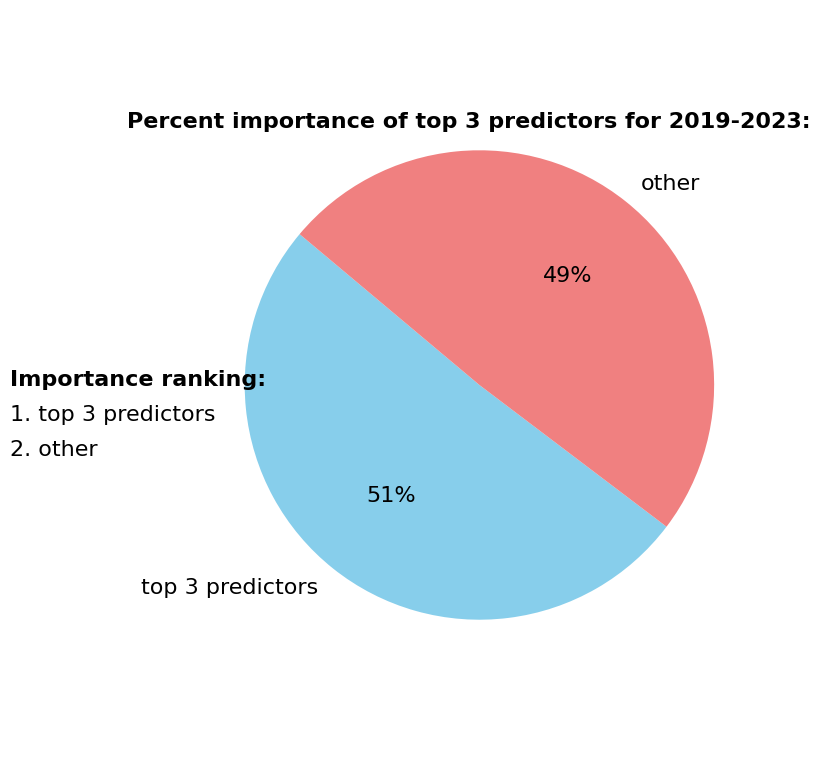

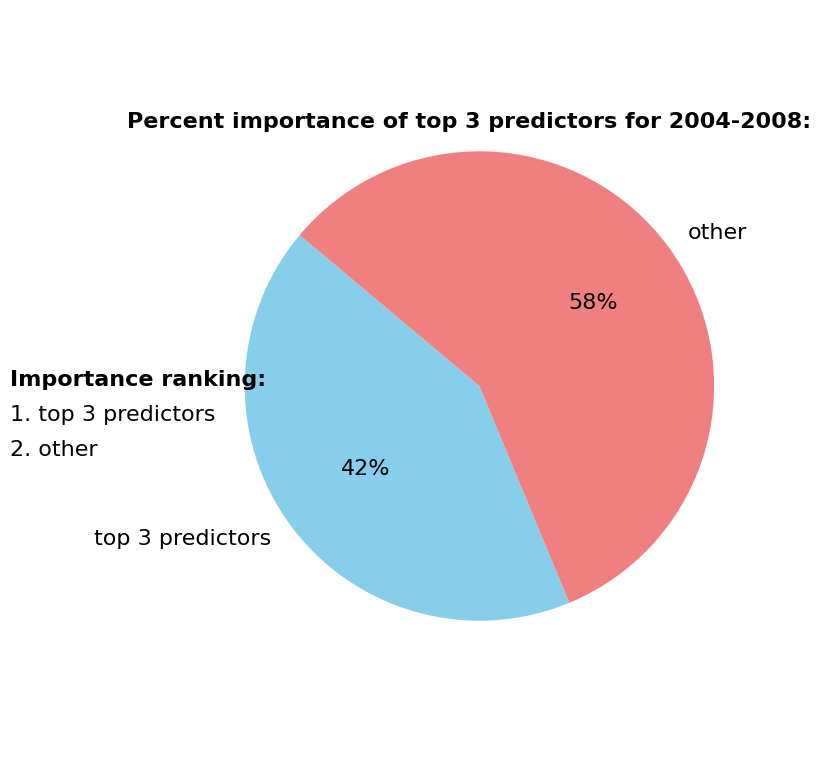

In [ ]:
import matplotlib.pyplot as plt
import math

def create_feature_plot_top3(features, means, setting):
    top3_mean = sum(means[:3])
    other_means = sum(means[3:])

    plt.figure(figsize=(8, 8))
    colors = ['skyblue', 'lightcoral']

    if setting == 0:
        #plt.title('Percent importance of top 3 predictors for 2004-2008', fontweight='bold')
        plt.text(-1.5, 1.1, 'Percent importance of top 3 predictors for 2004-2008:', fontsize=16, color='black', weight='bold')

    else:
        #plt.title('Percent importance of top 3 predictors for 2019-2023', fontweight='bold')
        plt.text(-1.5,1.1, 'Percent importance of top 3 predictors for 2019-2023:',  fontsize=16, color='black', weight='bold')

    features = ["top 3 predictors", "other"]
    means = [top3_mean, other_means]

    def autopct_format(pct):
        return f'{round(pct)}%'

    wedges, texts, autotexts = plt.pie(means, labels=features, colors=colors, autopct=autopct_format, startangle=140)


    for text in texts:
        text.set_fontsize(16)
    for autotext in autotexts:
        autotext.set_fontsize(16)

    plt.axis('equal')
    plt.text(-2, 0, 'Importance ranking:', fontsize=16, color='black', weight='bold')


    for i, feature in enumerate(features, start=1):
        plt.text(-2, -i * 0.15, f"{i}. {feature}", fontsize=16, color='black')

    plt.tight_layout()
    plt.show()

create_feature_plot_top3(features_current, means_current, 1)

create_feature_plot_top3(features_past, means_past, 0)

# Interpreting comparison graph

The biggest change we see is

In [ ]:
# so I don't need to rerun this code if I ever need it again

current_means.to_csv('current_means.csv', index=False)
past_means.to_csv('past_means.csv', index=False)

In [ ]:
# visualizing some decision trees (with unscaled data so the nodes are easier to interprete)

import pandas as pd
import numpy as np

big_df = pd.read_csv("/content/Organized_Data.csv")


print(big_df['Year'].unique()) # to see which years are included

# initial preprocessing
# for random forests we should binary encode all the categorical variables


big_df = big_df[pd.notna(big_df['All_NBA'])]
big_df['All_NBA'] = big_df['All_NBA'].apply(lambda x: 0 if x == False else 1)
big_df.drop(big_df.columns[0], axis=1, inplace=True) # we dont need names
big_df.drop("All_NBA_Team", axis = 1, inplace=True)

# we will delete voting points at all to prevent our analysis from being arbitrary

big_df.drop("Voting_Points", axis = 1, inplace=True)

# encode the positions as numbers
counter = 0
for pos in big_df['Pos'].unique():
  print(pos)
  big_df['Pos'] = big_df['Pos'].apply(lambda x: counter if x == pos else x)
  counter += 1



# making the datasets for each time period; 'past' will store the data from 2004-2008, and 'current' will store data from over a decade later, i.e. 2019- 2023


past = big_df[big_df['Year'] <= 2008]
past.drop('Year', axis=1, inplace= True)

current = big_df[(big_df['Year'] >= 2019) & (big_df['Year'] < 2024)] #remove year 2024 since the team hasnt been choosen yet
current.drop('Year', axis=1, inplace = True)

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024]
Frontcourt
Backcourt


<ipython-input-32-5ae834ff6aa1>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past.drop('Year', axis=1, inplace= True)
<ipython-input-32-5ae834ff6aa1>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current.drop('Year', axis=1, inplace = True)


Testing Accuracy: 0.994535519125683


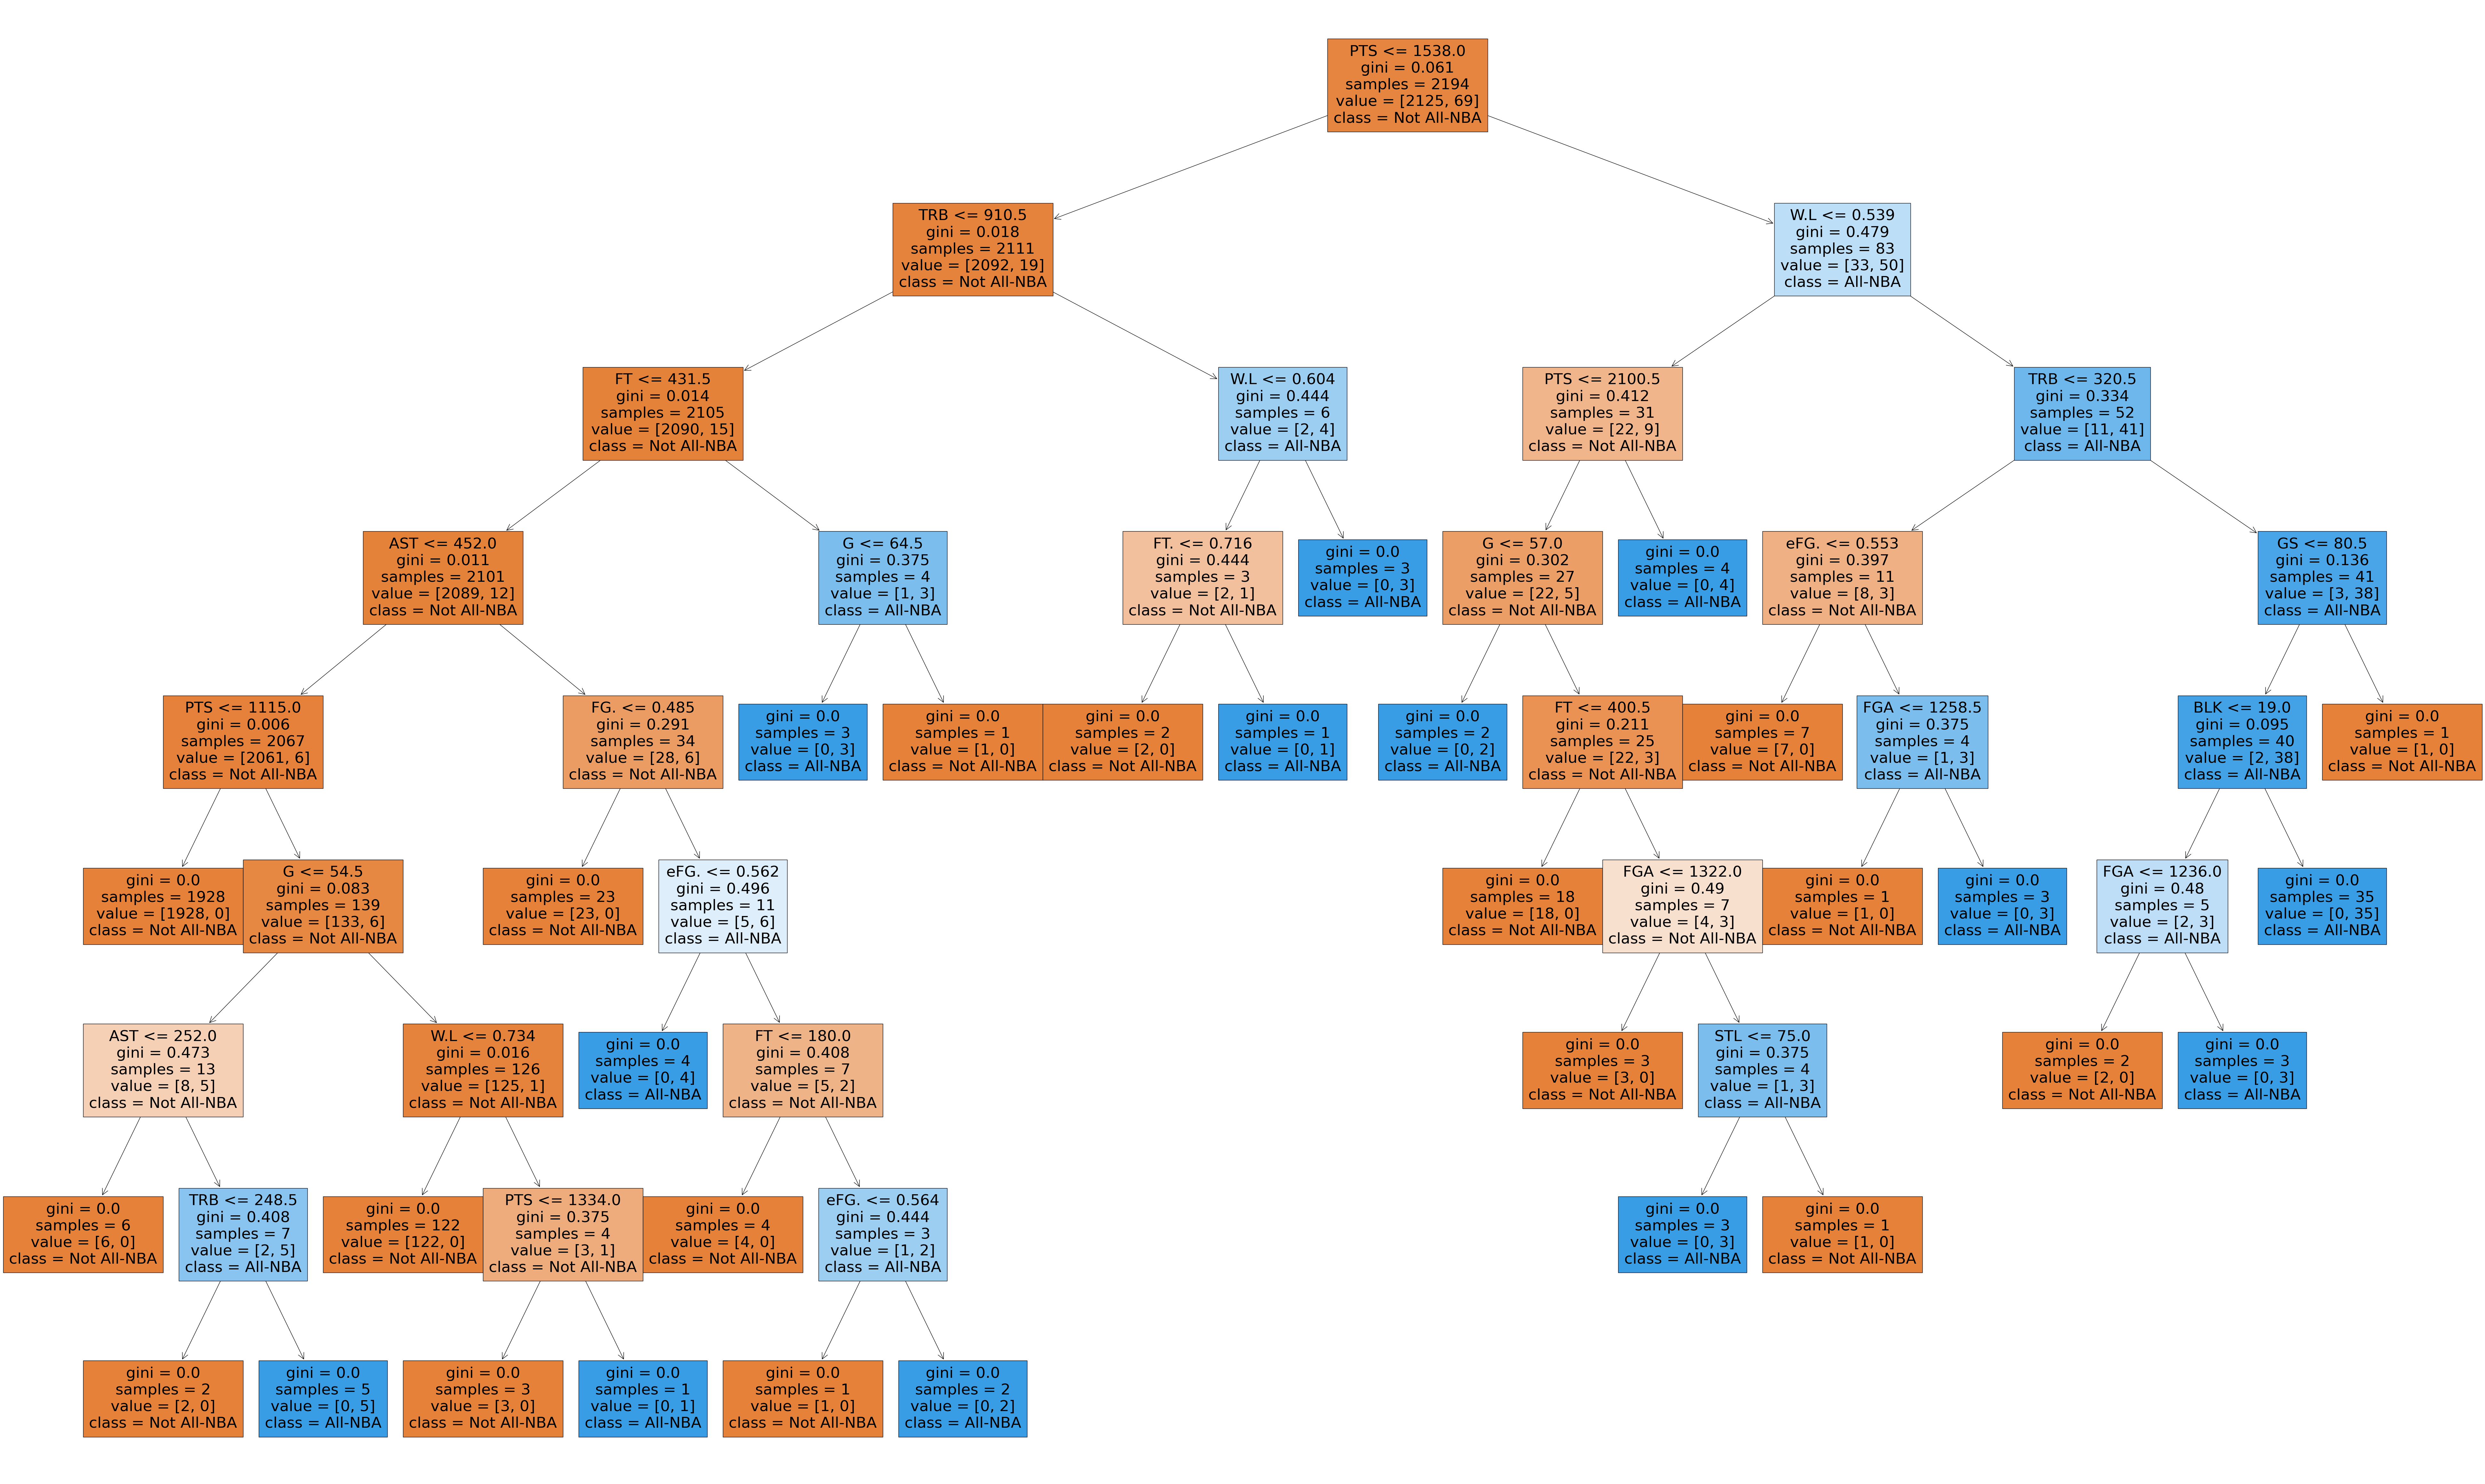

In [ ]:
def draw_decision_tree(df):
    import matplotlib.pyplot as plt
    from sklearn.tree import DecisionTreeClassifier, plot_tree
    from sklearn.model_selection import train_test_split

    y = df['All_NBA']
    X = df.drop(['All_NBA', 'Pos'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)


    testing_accuracy = clf.score(X_test, y_test)
    print("Testing Accuracy:", testing_accuracy)

    plt.figure(figsize=(100, 60))
    plot_tree(clf, feature_names=X.columns, class_names=['Not All-NBA', 'All-NBA'], filled=True, impurity=True)
    plt.show()


draw_decision_tree(current)